In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd
from catboost import Pool, CatBoostRegressor

### Можно ли решить задачу с наскока?

Сперва стоит подгрузить данные и посмотреть на то, с чем нам придётся работать.

В этои соревновании участникам предоставляются 4 набора из пар файлов (train и test):
1. train_main.parquet (279 признаков + ключ)
2. train_card_spending.parquet (630 признаков + ключ)
3. train_mcc_operations.parquet (1640 признаков + ключ)
4. train_mcc_preferences.parquet (2112 признаков + ключ)

Для простоты, попробуем использовать первый набор (*_main.parquet*).

#### Данные с признаками (1 из 4):


In [3]:
train = pd.read_parquet('train_main.parquet')
test = pd.read_parquet('test_main.parquet')

In [4]:
print('Данные для обучения:', train.shape)
print('Тестовые данные:', test.shape)

Данные для обучения: (213345, 280)
Тестовые данные: (318451, 280)


In [5]:
train.head(n = 5)

,user_id,app_children_cnt,app_dependent_cnt,app_family_cnt,app_income_app,app_real_estate_ind,app_vehicle_ind,avg_dep_avg_balance_12month_amt,avg_dep_avg_balance_12month_amt_term,avg_dep_avg_balance_12month_amt_term_savings,...,savings_sum_oms_debet_3m,savings_sum_oms_debet_6m,savings_sum_oms_debet_9m,savings_sum_oms_debet_12m,savings_service_model_cd,savings_pension_flg,savings_deposit_flg,savings_safe_acc_flg,savings_broker_flg,savings_oms_flg
0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4027.373535,...,34.613216,0.000000,4.310414,75.214180,Массовый,0,0,1,0,0
1,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.237672,0.000000,0.000000,0.000000,Массовый,0,0,1,0,0
2,12,0.0,0.0,0.0,105372.960938,0.0,0.0,315208.781250,NaN,274816.375000,...,0.000000,53.134129,90.025238,0.000000,Массовый,0,0,1,0,0
3,13,1.0,0.0,3.0,0.000000,0.0,0.0,43187.953125,NaN,5277.233887,...,0.000000,22.276114,82.070015,117.386795,Массовый,0,0,1,0,0
4,15,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,33.072178,Массовый,0,0,1,0,0


#### Особенности данных

Сразу видно очень много пропусков. 

Наверное с пропусками даже придётся что-то делать, ведь где-то их 50% или больше.

In [6]:
missing_values = train.isnull().sum().sort_values(ascending = False)
missing_values = missing_values[missing_values > 0]
print('\nColumns with missing values:\n', missing_values)


Columns with missing values:
 vehicle_counrty_type_nm    206739
max_amt_foreign_cur_5y     201136
max_amt_dep_6m             182526
min_amt_term_g1y           180330
max_amt_dep_act            175074
                            ...  
cnt_grow_5y                    26
cnt_dep_closed_5y              26
cnt_early_withdraw_5y          26
cnt_dep_6m                     26
cnt_dep_5y                     26
Length: 167, dtype: int64


Интересно, а в тестовых данных же всё точно так же? 

Наверное, нужно будет это проверить 🤔️️️️️️

Для некоторых алгоритмов будет неловко, если появятся новые признаки с пропусками, которых не было в обучающих данных  👀️️️️️️

In [7]:
#проверка для тестовых данных
missing_values_test = test.isnull().sum().sort_values(ascending = False)
missing_values_test = missing_values_test[missing_values_test > 0]
print('\nColumns with missing values:\n', missing_values_test)


Columns with missing values:
 vehicle_counrty_type_nm    309569
max_amt_foreign_cur_5y     303573
min_amt_term_g1y           276685
max_amt_dep_6m             255802
max_amt_dep_act            250547
                            ...  
cnt_foreign_cur_5y             97
cnt_dep_closed_5y              97
cnt_dep_6m                     97
cnt_dep_5y                     97
customer_age                    1
Length: 168, dtype: int64


#### Типы  данных

Стоит верхнеуровнево посмотреть что находится внутри. Особенно интересуют категориальные признаки.

In [2]:
train.dtypes.value_counts()

NameError: name 'train' is not defined

Категориальные признаки стоит отдельно выделить и сохранить для Catboost.

In [9]:
features = train.columns

categorical_features = train[features].select_dtypes(include=['object']).columns

for feature in categorical_features:
    train[feature] = train[feature].astype(str)

categorical_features_indices = np.where(train.dtypes == 'object')[0]
print(categorical_features_indices)

[ 33  47  57  63  64  93 122 274]


Для первого подхода к снаряду, этого хватит. Не хватает только целевой переменной.

### Целевая переменная



In [2]:
target = pd.read_csv('train_target.csv')
target.shape

(213345, 2)

In [3]:
target.head(5)

,user_id,target
0,9,0.00000
1,11,0.00000
2,12,219932.90625
3,13,631.77002
4,15,0.00000


Мы решаем задачу регрессии. Из описания соревнования, нам требуется предсказать:

> 50 перцентиль распределения суммарных остатков на всех накопительных счетах клиента на горизонте +2 мес. от отчетной даты



In [4]:
target['target'].describe()

count    2.133450e+05
mean     2.210490e+05
std      9.894988e+05
min     -7.100000e-01
25%      0.000000e+00
50%      3.174000e+01
75%      1.000027e+05
max      1.015605e+08
Name: target, dtype: float64

Целевая переменная точно требует ее преобразовать. Посмотрим как она выглядит после log1p:

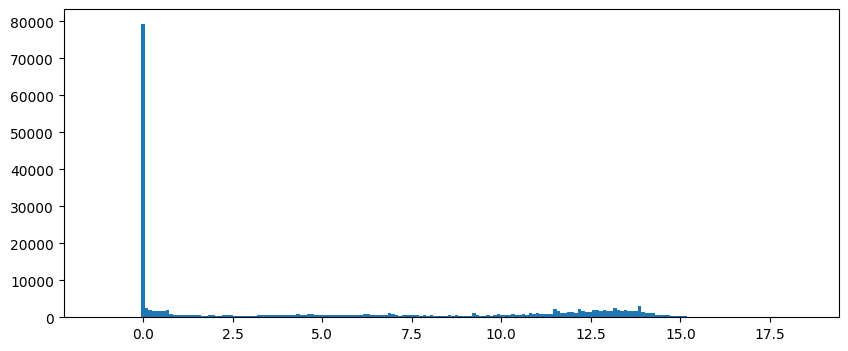

In [5]:
plt.figure(figsize=(10,4))

plt.hist(np.log1p(target['target']), bins = 200);

В распределении очень много нулей, так что стоит смотреть чуть уже:

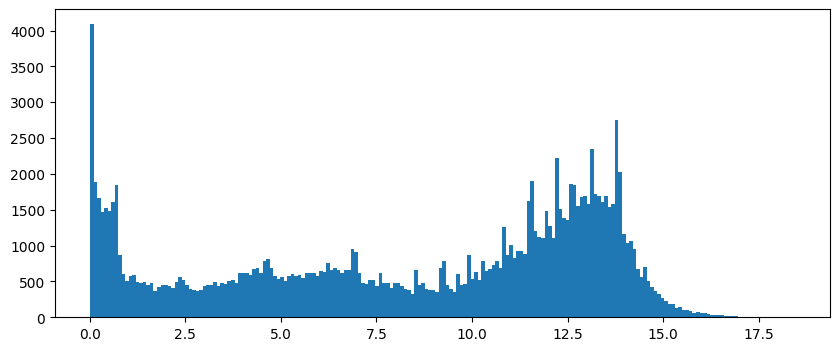

In [6]:
plt.figure(figsize=(10,4))

plt.hist(np.log1p(target.loc[target['target'] > 0, 'target']), bins = 200);

Распределение выглядит очень похожим на смесь:
- Есть клиенты с значениями около нуля
- Есть компонента смеси с центром в районе 6, то есть ~400 (np.exp(6) - 1)
- Есть компонента справа, с центров в районе 13, то есть ~440,000
- И есть еще клиенты с ровно 0, которых мы убрали с графика

Выглядит заманчиво и для ML, и визуализации. Но нас пока интересует только сабмит.

### Catboost

Начнём собирать всё что нам потребуется дя обучения Catboost-а.

- Будем ли мы проверять, что порядок `user_id` полностью совпадает в train и target?
- Будем ли мы сразу настраивать свою валидацию и делить данные?
- Или может быть будем что-либо преобразовывать?

Нет, нас интересует catboost сабмит ASAP 🤗️️️️️️ 

In [7]:
train_main = pd.read_parquet('train_main.parquet')
train_main.shape

(213345, 280)

In [8]:
#данные из других файлов
train_card = pd.read_parquet('train_card_spending.parquet') #, engine = 'pyarrow', chunksize = '64MB'
train_card.shape

(213345, 631)

In [9]:
train_mcc_operations = pd.read_parquet('train_mcc_operations.parquet') #, engine = 'pyarrow', chunksize = '64MB'
train_mcc_operations.shape

(213345, 1641)

In [10]:
train_mcc_preferences = pd.read_parquet('train_mcc_preferences.parquet') #, engine = 'pyarrow', chunksize = '64MB'
train_mcc_preferences.shape

(213345, 2113)

Удаляем колонки с пропусками > 90% 

In [11]:
missing_values_train_main = train_main.isnull().sum().sort_values(ascending = False)
missing_values_train_main = missing_values_train_main[missing_values_train_main > 0]
print('\nColumns with missing values:\n', missing_values_train_main)


Columns with missing values:
 vehicle_counrty_type_nm    206739
max_amt_foreign_cur_5y     201136
max_amt_dep_6m             182526
min_amt_term_g1y           180330
max_amt_dep_act            175074
                            ...  
cnt_foreign_cur_5y             26
cnt_save_5y                    26
cnt_grow_5y                    26
cnt_term_g1y                   26
cnt_manage_5y                  26
Length: 167, dtype: int64


In [12]:
drop_col = []

empty_col_train_main = missing_values_train_main[missing_values_train_main > missing_values_train_main[0]*0.9]
train_main = train_main.drop(columns = list(empty_col_train_main.index))
drop_col += empty_col_train_main.index.tolist()
print(drop_col)
train_main.shape

['vehicle_counrty_type_nm', 'max_amt_foreign_cur_5y']


C:\Users\Aleksandr\AppData\Local\Temp\ipykernel_11756\1940871018.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  empty_col_train_main = missing_values_train_main[missing_values_train_main > missing_values_train_main[0]*0.9]


(213345, 278)

In [13]:
missing_values_train_card = train_card.isnull().sum().sort_values(ascending = False)
missing_values_train_card = missing_values_train_card[missing_values_train_card > 0]
print('\nColumns with missing values:\n', missing_values_train_card)


Columns with missing values:
 sum_tr_house_rental_6          213345
sum_tr_house_rental_3          213345
sum_tr_house_rental_12         213345
sum_tr_house_rental_1          213345
sum_tr_financial_services_1    213330
                                ...  
cc_sum_trns_3m                  26877
cc_sum_trns_12m                 26877
cc_cnt_trns_12m                 26877
cc_avg_trns_1m                  26877
cc_avg_trns_12m                 26877
Length: 630, dtype: int64


In [14]:
empty_col_train_card = missing_values_train_card[missing_values_train_card > missing_values_train_card[0]*0.9]
train_card = train_card.drop(columns = list(empty_col_train_card.index))
drop_col += empty_col_train_card.index.tolist()
print(drop_col)
train_card.shape

C:\Users\Aleksandr\AppData\Local\Temp\ipykernel_11756\715237877.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  empty_col_train_card = missing_values_train_card[missing_values_train_card > missing_values_train_card[0]*0.9]


['vehicle_counrty_type_nm', 'max_amt_foreign_cur_5y', 'sum_tr_house_rental_6', 'sum_tr_house_rental_3', 'sum_tr_house_rental_12', 'sum_tr_house_rental_1', 'sum_tr_financial_services_1', 'sum_tr_financial_services_3', 'sum_tr_foreign_1', 'sum_tr_financial_services_6', 'sum_tr_financial_services_12', 'sum_tr_foreign_3', 'sum_tr_foreign_6', 'sum_tr_foreign_12', 'sum_tr_gambling_1', 'sum_tr_lottery_1m', 'sum_tr_computer_program_retail_1', 'sum_tr_duty_free_1', 'sum_tr_restaurants_delivery_1', 'sum_tr_gambling_3', 'sum_tr_lottery_3m', 'sum_tr_computer_program_retail_3', 'sum_tr_gambling_6', 'sum_tr_games_store_1', 'sum_tr_auto_rental_1', 'sum_tr_membership_clubs_1', 'sum_tr_lottery_6m', 'sum_tr_jewelry_retail_1', 'sum_tr_insurance_1', 'sum_tr_duty_free_3', 'sum_tr_cleaning_services_1', 'sum_tr_restaurants_delivery_3', 'sum_tr_airlines_1', 'sum_tr_charity_1', 'sum_tr_computer_program_retail_6', 'sum_tr_auto_rental_3', 'sum_tr_gambling_12', 'sum_tr_office_supplies_1', 'sum_tr_games_store_3', 

(213345, 496)

In [20]:
missing_values_train_mcc_operations = train_mcc_operations.isnull().sum().sort_values(ascending = False)
missing_values_train_mcc_operations = missing_values_train_mcc_operations[missing_values_train_mcc_operations > 0]
print('\nColumns with missing values:\n', missing_values_train_mcc_operations)


Columns with missing values:
 sum_most_popular_mcc_7321_1m     213345
sum_most_popular_mcc_9211_1m     213344
sum_most_popular_mcc_9211_3m     213343
sum_most_popular_mcc_7321_6m     213342
sum_most_popular_mcc_7321_3m     213342
                                  ...  
cnt_most_popular_mcc_6538_12m     63339
cnt_most_popular_mcc_6540_12m     63339
cnt_most_popular_mcc_5251_12m     63339
cnt_most_popular_mcc_7011_12m     63339
cnt_most_popular_mcc_5231_12m     63339
Length: 1640, dtype: int64


In [21]:
empty_col_train_mcc_operations = missing_values_train_mcc_operations[missing_values_train_mcc_operations > missing_values_train_mcc_operations[0]*0.9]
train_mcc_operations = train_mcc_operations.drop(columns = list(empty_col_train_mcc_operations.index))
train_mcc_operations.shape

(213345, 935)

In [22]:
missing_values_train_mcc_preferences = train_mcc_preferences.isnull().sum().sort_values(ascending = False)
missing_values_train_mcc_preferences = missing_values_train_mcc_preferences[missing_values_train_mcc_preferences > 0]
print('\nColumns with missing values:\n', missing_values_train_mcc_preferences)


Columns with missing values:
 preferences_div_sum_tr_cat_entertainment_1m    107148
preferences_div_sum_tr_MCC_code_5013_1m        107148
preferences_div_sum_tr_MCC_code_5137_1m        107148
preferences_div_sum_tr_MCC_code_5131_1m        107148
preferences_div_sum_tr_MCC_code_5122_1m        107148
                                                ...  
preferences_div_cnt_tr_MCC_code_5967_12m        63588
preferences_div_cnt_tr_MCC_code_5964_12m        63588
preferences_div_cnt_tr_MCC_code_5950_12m        63588
preferences_div_cnt_tr_MCC_code_5949_12m        63588
preferences_div_cnt_tr_MCC_code_5948_12m        63588
Length: 2112, dtype: int64


In [23]:
empty_col_train_mcc_preferences = missing_values_train_mcc_preferences[missing_values_train_mcc_preferences > missing_values_train_mcc_preferences[0]*0.8]
train_mcc_preferences = train_mcc_preferences.drop(columns = list(empty_col_train_mcc_preferences.index))
train_mcc_preferences.shape

(213345, 1057)

In [24]:
missing_values_train = train.isnull().sum().sort_values(ascending = False)
missing_values_train = missing_values_train[missing_values_train > 0]
print('\nColumns with missing values:\n', missing_values_train)


Columns with missing values:
 vehicle_counrty_type_nm    206739
max_amt_foreign_cur_5y     201136
max_amt_dep_6m             182526
min_amt_term_g1y           180330
max_amt_dep_act            175074
                            ...  
cnt_grow_5y                    26
cnt_dep_closed_5y              26
cnt_early_withdraw_5y          26
cnt_dep_6m                     26
cnt_dep_5y                     26
Length: 167, dtype: int64


Объединение данных из разных файлов

In [26]:
train_card = dd.from_pandas(train_card, npartitions = 3)
train_mcc_operations = dd.from_pandas(train_mcc_operations, npartitions = 3)
train_mcc_preferences = dd.from_pandas(train_mcc_preferences, npartitions = 3)

In [15]:
train = pd.merge(train_main, train_card, on = 'user_id', how = 'left')
train.shape

(213345, 773)

In [ ]:
train = pd.merge(train, train_mcc_operations, on = 'user_id', how = 'left')
train.shape

(Delayed('int-ca3c6baa-dfd7-4e7c-84f4-315c15556af4'), 1707)

In [ ]:
train = pd.merge(train, train_mcc_preferences, on = 'user_id', how = 'left')
train.shape

(Delayed('int-8e171aa0-8e9d-49ad-876e-1d2110b11791'), 2763)

In [ ]:
#train.shape()
#train.dropna()
#train.head()

In [30]:
train = train.compute()

ignoring exception in ensure_cleanup_on_exception
Traceback (most recent call last):
  File "c:\Users\askor\AppData\Local\Programs\Python\Python37\lib\site-packages\dask\dataframe\shuffle.py", line 914, in ensure_cleanup_on_exception
    yield
  File "c:\Users\askor\AppData\Local\Programs\Python\Python37\lib\site-packages\dask\dataframe\shuffle.py", line 929, in shuffle_group_3
    p.append(d, fsync=True)
  File "c:\Users\askor\AppData\Local\Programs\Python\Python37\lib\site-packages\partd\encode.py", line 23, in append
    data = valmap(self.encode, data)
  File "c:\Users\askor\AppData\Local\Programs\Python\Python37\lib\site-packages\toolz\dicttoolz.py", line 85, in valmap
    rv.update(zip(d.keys(), map(func, d.values())))
  File "c:\Users\askor\AppData\Local\Programs\Python\Python37\lib\site-packages\partd\pandas.py", line 186, in serialize
    return b''.join(map(frame, frames))
  File "c:\Users\askor\AppData\Local\Programs\Python\Python37\lib\site-packages\partd\utils.py", line 40

MemoryError: 

ignoring exception in ensure_cleanup_on_exception
Traceback (most recent call last):
  File "c:\Users\askor\AppData\Local\Programs\Python\Python37\lib\site-packages\dask\dataframe\shuffle.py", line 914, in ensure_cleanup_on_exception
    yield
  File "c:\Users\askor\AppData\Local\Programs\Python\Python37\lib\site-packages\dask\dataframe\shuffle.py", line 929, in shuffle_group_3
    p.append(d, fsync=True)
  File "c:\Users\askor\AppData\Local\Programs\Python\Python37\lib\site-packages\partd\encode.py", line 23, in append
    data = valmap(self.encode, data)
  File "c:\Users\askor\AppData\Local\Programs\Python\Python37\lib\site-packages\toolz\dicttoolz.py", line 85, in valmap
    rv.update(zip(d.keys(), map(func, d.values())))
  File "c:\Users\askor\AppData\Local\Programs\Python\Python37\lib\site-packages\partd\pandas.py", line 186, in serialize
    return b''.join(map(frame, frames))
  File "c:\Users\askor\AppData\Local\Programs\Python\Python37\lib\site-packages\partd\utils.py", line 40

In [16]:
features = train.columns

categorical_features = train[features].select_dtypes(include=['object']).columns

for feature in categorical_features:
    train[feature] = train[feature].astype(str)

categorical_features_indices = np.where(train.dtypes == 'object')[0]
print(categorical_features_indices)

[ 33  47  57  63  64  92 121 272 278 279 280 281 282 283 284 285]


In [ ]:
#categorical_features_indices += categorical_features_indices_card
#categorical_features += categorical_features_card

In [17]:
train_pool = Pool(data = train, 
                  label = np.log1p(target['target']), 
                  cat_features = categorical_features_indices)

#### Обучение

Главные настройки, которые нам стоит учесть:

- Так как метрика соревнования это RMSLE, а мы уже логарифмировали (log1p) целевую переменную, оптимизировать мы будем RMSE
- У нас много пропусков в данных, поэтому нам очень повезло что у Catboost есть настройка nan_mode

In [18]:
model = CatBoostRegressor(iterations = 100,
                          early_stopping_rounds = 100, 
                          depth = 6,
                          l2_leaf_reg = 1,
                          learning_rate = 0.1, 
                          loss_function = 'RMSE', 
                          nan_mode = 'Min', 
                          random_seed = 314,
                          verbose = 10)


In [19]:
model.fit(train_pool)

0:	learn: 5.1189322	total: 659ms	remaining: 1m 5s
10:	learn: 2.7810142	total: 6.16s	remaining: 49.8s
20:	learn: 2.2597227	total: 10.9s	remaining: 41s
30:	learn: 2.1469454	total: 15.3s	remaining: 34.1s
40:	learn: 2.1033715	total: 19.7s	remaining: 28.3s
50:	learn: 2.0781013	total: 23.6s	remaining: 22.7s
60:	learn: 2.0616375	total: 27.6s	remaining: 17.6s
70:	learn: 2.0475776	total: 31.6s	remaining: 12.9s
80:	learn: 2.0361002	total: 35.5s	remaining: 8.34s
90:	learn: 2.0262115	total: 39.3s	remaining: 3.88s
99:	learn: 2.0186628	total: 42.9s	remaining: 0us


Мы успешно обучили модель 🌟️️️️️️

И вправду — зачем нам валидация, если можно ее сразу отправить в соревнование и узнать наш результат на лидерборде? Он же не будет прямо сильно хуже чем в логе обучения? (ведь правда, да?)

### Подготовка сабмита

Посмотрим на пример рабочего бейзлайн решения. 

Именно в таком формате платформа ждет от нас решения:

In [20]:
sample = pd.read_csv('sample_submit_naive.csv')
sample.shape

(318451, 2)

In [21]:
sample.head(5)

,user_id,predict
0,1000008,1.004656e+06
1,1000009,0.000000e+00
2,1000013,5.047758e+02
3,1000016,1.680799e+05
4,1000017,2.222542e+02


С форматом тоже всё понятно. 

Важно заметить, что предсказания от нас ждут без преобразований целевой переменной, так что нужно будет сделать обратные преобразования предсказаний нашей модели.

#### Использование модели 

Тестовые данные у нас уже есть, но их нужно подготовить для формата Catboost-а.

In [23]:
test_main = pd.read_parquet('test_main.parquet')

In [24]:
test_card = pd.read_parquet('test_card_spending.parquet') #, engine = 'pyarrow', chunksize = '64MB'
test_mcc_operations = pd.read_parquet('test_mcc_operations.parquet') #, engine = 'pyarrow', chunksize = '64MB'
test_mcc_preferences = pd.read_parquet('test_mcc_preferences.parquet') #, engine = 'pyarrow', chunksize = '64MB'

In [25]:
ghj = train_card.columns.values.tolist()
print(ghj)

['user_id', 'cat_maxspend_v1_1', 'cat_maxspend_v1_12', 'cat_maxspend_v1_3', 'cat_maxspend_v1_6', 'cat_maxspend_v2_1', 'cat_maxspend_v2_12', 'cat_maxspend_v2_3', 'cat_maxspend_v2_6', 'cc_avg_trns_12m', 'cc_avg_trns_1m', 'cc_cnt_trns_12m', 'cc_sum_trns_12m', 'cc_sum_trns_3m', 'cnt_mcc_codes_1', 'cnt_mcc_codes_12', 'cnt_mcc_codes_3', 'cnt_mcc_codes_6', 'cnt_tr_abroad_1', 'cnt_tr_abroad_12', 'cnt_tr_abroad_3', 'cnt_tr_abroad_6', 'cnt_tr_airlines_1', 'cnt_tr_airlines_12', 'cnt_tr_airlines_3', 'cnt_tr_airlines_6', 'cnt_tr_alkochol_12m', 'cnt_tr_alkochol_1m', 'cnt_tr_alkochol_3m', 'cnt_tr_alkochol_6m', 'cnt_tr_all_1', 'cnt_tr_all_12', 'cnt_tr_all_3', 'cnt_tr_all_6', 'cnt_tr_all_7d', 'cnt_tr_appliance_retail_1', 'cnt_tr_appliance_retail_12', 'cnt_tr_appliance_retail_3', 'cnt_tr_appliance_retail_6', 'cnt_tr_auto_rental_1', 'cnt_tr_auto_rental_12', 'cnt_tr_auto_rental_3', 'cnt_tr_auto_rental_6', 'cnt_tr_auto_repair_12m', 'cnt_tr_auto_repair_1m', 'cnt_tr_auto_repair_3m', 'cnt_tr_auto_repair_6m', 

In [25]:
test = pd.merge(test_main, test_card, on = 'user_id', how = 'left')
test.shape

(318451, 910)

In [36]:
test.drop(columns = drop_col, inplace = True)
test.shape

(318451, 773)

In [39]:
test_pool = Pool(data = test, 
                 cat_features = categorical_features_indices)

In [40]:
test_predict = model.predict(test_pool)
test_predict.shape

(318451,)

Обратные преобразования (не забываем -1):

In [41]:
test_full_predict = np.exp(test_predict) - 1

#### Упаковка сабмита

Так как мы торопимся отправить решение, мы снова доверимся воле случая, что все 'user_id' отсортированы за нас 🌚️️️️️️

И мы просто перепишем предсказания в исходном сабмит файле.

In [42]:
sample['predict'] = test_full_predict

In [43]:
sample.head(5)

,user_id,predict
0,1000008,312525.759671
1,1000009,-0.029813
2,1000013,14.334838
3,1000016,625.563534
4,1000017,11.710956


Финишная прямая — пишем файл:


In [44]:
sample.to_csv('submit_baseline_catboost.csv', index=False)

И... результат на паблике это 4.169190539294088	

- Это лучше чем наивный сабмит с 5.848489205052006
- Но это точно не метрика, показываемая в логах при обучении
- И этот результат вряд ли пошёл бы в продакшен

Можно ли это улучшить? 